In [21]:
import pandas as pd
import numpy as np
import category_encoders as ce

# Библиотека для анализа настроения отзывов
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Для вычисления координат
from geopy.distance import geodesic as GD

# Для нормализации, стандартизации
from sklearn import preprocessing

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

# Для графиков
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.style.use('ggplot')

[nltk_data] Downloading package vader_lexicon to C:\Users\Dmitriy
[nltk_data]     Chuprinko\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### <center> Исследование данных

In [22]:
hotels = pd.read_csv('data/hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [23]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [24]:
# Списки с признаками непрерывного типа и признаков типа object
print(hotels.select_dtypes(np.number).columns.to_list())
print(hotels.select_dtypes('object').columns.to_list())

['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'lat', 'lng']
['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review']


больше половины признаков имеют объектный тип данных

In [25]:
print(f'Количество уникальных названий отелей: {hotels["hotel_name"].nunique()}\n')

# Даты первого и последнего отзывов
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
print(f'Первая и последняя даты отзывов:\n{hotels["review_date"].agg(["min", "max"])}\n')

# Делаем срез и разделяем теги
tags_list = hotels['tags'].apply(lambda x: x[3:-3].split(" ', ' "))
tags = tags_list.explode(ignore_index=True)
print(f'Количество уникальных тегов: {tags.nunique()}\n')

print(f'Самый частый тег: {tags.mode()[0]}\n')

# С помощью регулярного выражения находим строки с тегом "остановок на ночь"
reg = 'S\w{5}\s\d+\sn\w{4,5}'
night_tags = tags.str.findall(reg).str.get(0)
print(f'Самый частый тег с указанием остановок на ночь: {night_tags.value_counts().index[0]}')

data = hotels.copy()

Количество уникальных названий отелей: 1492

Первая и последняя даты отзывов:
min   2015-08-04
max   2017-08-03
Name: review_date, dtype: datetime64[ns]

Количество уникальных тегов: 2368

Самый частый тег: Leisure trip

Самый частый тег с указанием остановок на ночь: Stayed 1 night


Эта информация поможет нам вывести новые признаки

### <center> Заполнение пропущенных значений

Из-за ошибок в адресах некоторых отелей, были утеряны данные о координатах этих отелей. Зная название этих отелей, а так же страну и город, можно найти их точные координаты.

При помощи библиотеки geopy находим отсутствующие координаты:

from geopy.geocoders import Nominatim  
geolocator = Nominatim(user_agent = "zhyravkovv@mail.ru")  
location = geolocator.geocode("Wahringer Strasse 12 09 Alsergrund 1090 Vienna Austria")  
print(location.address)

In [26]:
# Список названий отелей с пропущенными координатами
names_list = data[data['lat'].isnull()]['hotel_name'].unique().tolist()

# Создаём список с координатами отелей из предыдущего списка.
# Координаты можно создать с помощью библиотеки NumPy, где широта и долгота будут располагаться в пределах той или иной страны
coordinates = [
    (48.219555, 16.285566), (48.888860, 2.333190), (48.209389, 16.353491), (48.220310, 16.355881),
    (48.875223, 2.323385), (48.245914, 16.341188), (48.213558, 16.379923), (41.391430, 2.177890),
    (48.220856, 16.366642), (48.188835, 16.383810), (48.186620, 16.420550), (48.216705, 16.359819),
    (48.839701, 2.323519), (48.233379, 16.345510), (41.383263, 2.162926), (41.392429, 2.167500), (48.209530, 16.351515)
]

# Заполняем пропуски
for name, coord in zip(names_list, coordinates):
    data.loc[data['hotel_name'] == name, ['lat', 'lng']] = coord[0], coord[1]
    
data[['lat', 'lng']].isnull().sum()

lat    0
lng    0
dtype: int64

### <center> Извлечение информации из строковых данных и создание новых признаков

In [27]:
# Извлекаем название страны из адреса
data['country'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1])

# Извлекаем название города из адреса
def get_city(arg):
    if arg.split()[-2] == 'United':
        return arg.split()[-5]
    else:
        return arg.split()[-2]
    
data['city'] = data['hotel_address'].apply(get_city)

Создадим признак *distance* расстояние от отеля до центра:

In [28]:
# Объединяем координаты в новый признак
data['coord'] = list(zip(data['lat'], data['lng']))

# Создаём таблицу с городами и координатами их центров
df_center = pd.DataFrame(
            {'city':['London',
                    'Amsterdam',
                    'Barcelona',
                    'Milan',
                    'Vienna',
                    'Paris'],
    'coord_center':[(51.5085, -0.12574),
                    (52.374, 4.88969),
                    (41.3888, 2.15899),
                    (45.4643, 9.18951),
                    (48.2085, 16.3721),
                    (48.8534, 2.3488)]}
)

# Объединяем таблицы по признаку "city"
data = data.merge(df_center, on = 'city', how = 'left')

# Функция для определения расстояние между координатами
def get_distance(coord):
    coord_hotels = coord['coord']
    coord_center = coord['coord_center']
    return round(GD(coord_hotels, coord_center).km, 1)

data['distance'] = data.apply(get_distance, axis = 1)

data = data.drop(['coord', 'coord_center'], axis=1)

In [29]:
# Редактируем признак тегов для удобства. Создадим столбец с количеством тегов в каждом отзыве
data['tags'] = tags_list
data['tags_cnt'] = tags_list.apply(lambda x: len(x))

# Сохраним топ 15 тегов
top_ten_tags = tags.value_counts().head(15).index.tolist()

# Создадим сигнальные признаки по топ 10 тегам
for tag in top_ten_tags:
    name_f = tag.lower().replace(' ', '_')
    data[name_f] = data['tags'].apply(lambda x: 1 if tag in x else 0)

# Преобразуем столбец с днями проверки отзывов
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0]).astype('int')

# Извлечем из даты возраст отзыва, год, месяц и день недели
data['review_age'] = (pd.to_datetime('today') - data['review_date']).dt.days
data['day_of_week'] = data['review_date'].dt.weekday
data['month'] = data['review_date'].dt.month
data['year'] = data['review_date'].dt.year

# Создаём списки с отсутствием позитивных и отсутствием негативных отзывов
no_negative_list = [
    'No Negative', ' Nothing', ' Nothing ', ' nothing', ' N A', ' None', ' ', ' N a', ' All good', ' Nothing really', ' none', ' nothing ', ' No complaints', ' Nil', ' Nothing really ',
    ' No', ' Nothing to dislike ', ' good', ' Everything was perfect ', ' Everything was great ', ' Everything was perfect', ' Absolutely nothing ', ' None ',' No complaints ', ' All good ',
    ' NA', ' n a', ' Nothing to dislike', ' Nothing at all', ' Nothing at all ', ' I liked it all ', ' nothing much', ' Can t think of anything ', ' Nothing all was great',' Faultless', ' nothing all good',
    ' Could not fault anything', ' No negative comments ',' Nothing to complain about ', ' NOTHING', ' Na', ' Everything was great', ' Can t think of anything', ' Liked everything', ' Non', ' Everything was good',
    ' All was good', ' Absolutely nothing', ' I liked everything', ' Not applicable',' Nothing to complain about', ' Everything was good ', ' Nothing all good', ' No thing', ' I liked everything ',' Everything was fine',
    ' Nothing in particular', ' nothing really', ' Location ', ' There was nothing I didn t like ',' No complaints at all ', ' Nothing everything was great ', ' Everything was fine ', ' no', ' all good', ' no complaints',
    ' Nothing all good ', ' Nothing it was perfect ', ' No negatives', ' No problems', ' Not a thing ', ' Nothing comes to mind ',' Nothing to mention', ' All ok', ' Liked everything ', ' Nothing in particular ',
    ' There was nothing we didn t like ',' Nothing it was perfect', ' No comment', ' Nothing I didn t like', ' Nothing I can think of ', ' nil', ' Nothing everything was perfect', ' We liked everything', ' Loved everything',
    ' Nothing to report ', ' It was all good', ' There was nothing to dislike ', ' Nothing comes to mind', ' Nothing everything was perfect ', ' Nothing to report',' There was nothing I didn t like',
    ' Nothing to say', ' There was nothing to dislike', ' non', ' No complaints at all',' Nothing everything was great', ' NOTHING ', ' We liked everything ', ' No dislikes', ' Nothing Everything was perfect ',
    ' It was all good ', ' No negatives ', ' Nothing I didn t like ', ' nothing not to like ', ' nothing to dislike',' No bad experience', ' Nothing bad', ' Not a thing', ' Loved everything ', ' Nothing special',
    ' What s not to like ',' Nothing to complain', ' nothing at all', ' No issues', ' Liked it all', ' There wasn t anything we didn t like ',' Nothing bad to say ', ' All great', ' Nothing we didn t like',
    ' No issues ', ' No comments',' There was nothing we didn t like', ' Can t think of a thing ', ' Nothing to not like', ' Nothing bad to say',' All was good ', ' Nothing could have been better ',
    ' Everything was excellent', ' There was nothing not to like',' Nothing negative to say ', ' Nothing to complain ', ' No bad experience ', ' Couldn t fault it ', ' All was perfect',' No problems at all',
    ' Everything was ok', ' N A ', ' Nothing could have been better', ' Nothing we didn t like ',' All fine', ' Cannot think of anything ', ' Nothing that I can think of ', ' It was perfect ', ' I have no complaints ',
    ' I can t think of anything ', ' Nothing to fault ', ' I loved everything', ' No faults', ' Nil ', ' I loved everything ',' Nothing much', ' Nothing bad ', ' Nothing to mention ', ' Loved it all ', ' Nothing Everything was great ',
    ' Nothing it was all good', ' Nothing It was perfect ', ' No bad experiences ', ' Everything was excellent ',' Nothing to say ', ' NIL', ' none ', ' Nothing springs to mind', ' nothing really ', ' Nithing', ' I liked it all',
    ' No negative comments', ' Liked it all ', ' no thing', ' Nothing to add', ' Loved it all', ' No bad experiences',' Noting', ' Zero', ' Nothin', ' Couldn t fault anything', ' Was all good', ' All was great', ' no complaints ',
    ' No dislikes ', ' All great ', ' It was all great ', ' There was nothing that we didn t like ', ' nothing to complain about',' No problems ', ' na', ' Nothing much ', ' Couldn t fault it', ' Nothing of note ', ' Everything perfect', ' Nothings',
    ' Nothing I can think of', ' Nothing specific', ' Nothing All good ', ' Nothing special ', ' Nothing of note',' There was nothing we did not like', ' Nothing was bad', ' Nothing All good', ' I can t think of anything', ' nothing to add',
    ' Nothing it was great', ' No comment ', ' No things', ' Nothing all great ', ' All was great ', ' Nothing bad to report ',' everything was perfect ', ' all ok', ' I cannot think of anything ', ' Nothing to fault', ' Everything good',
    ' Cannot think of anything',' No issues at all ', ' Nothing it was all great ', ' Not a lot', ' nothing special', ' No ', ' everything was great', ' Nothing all was good', ' Nothing all perfect', ' Nothing to not like ', ' Everything was fantastic',
    ' Everything ok', ' It was perfect', ' All perfect', ' Nothing everything was good', ' No comments ', ' Can t think of any ', ' Happy with everything', ' Can t fault anything', ' Nope', ' Not one thing ', 
]
no_positive_list = [
    'No Positive', ' Nothing', ' Nothing ', ' nothing', ' ', ' Not much ', ' Not much', ' Not a lot', ' Nothing at all', ' N A', ' None', ' Leaving', ' Nothing special', ' Nothing really', ' nothing ', ' No', ' Leaving ', ' No thing', ' Not a lot ', ' N a',
    ' NOTHING ', ' Nothing at all ', ' no', ' Nothing in particular', ' Nothing special ', ' NOTHING', ' Nothing much', ' Not alot', ' Nothing in particular ', ' Nothing really ', ' Absolutely nothing ', ' none', ' No comment', ' not much', ' Absolutely nothing',
    ' No breakfast', ' NA', ' Na', ' leaving', ' nothing special', ' Not much really', ' n a', ' Nothing particular', ' not a lot', ' No comments', 'Nothing good'
]

# Сигнальные признаки отсутсвия негативных и отсутвия позитивных отзывов
data['negative'] = data['negative_review'].apply(lambda x: 0 if x in no_negative_list else 1)
data['positive'] = data['positive_review'].apply(lambda x: 0 if x in no_positive_list else 1)

С помощью библиотеки *NLTK* проведём оценку положительных и негативных отзывов. Затем запишем результаты в отдельные признаки:

In [30]:
# Проанализируем отзывы
sid = SentimentIntensityAnalyzer()
data['scores_negative'] = data['negative_review'].apply(lambda x: sid.polarity_scores(x))
data['scores_positive'] = data['positive_review'].apply(lambda x: sid.polarity_scores(x))

# Создадим списки позитивных и отрицательных категорий результатов для применения цыкла
neg_cats = ['negative_neg', 'negative_neu', 'negative_pos', 'negative_compound']
pos_cats = ['positive_neg', 'positive_neu', 'positive_pos', 'positive_compound']

# Создадим признаки по категориям результатов
for neg_c, pos_c, i in zip(neg_cats, pos_cats, range(len(neg_cats))):
    data[neg_c] = data['scores_negative'].apply(lambda x: list(x.values())[i])
    data[pos_c] = data['scores_positive'].apply(lambda x: list(x.values())[i])

data = data.drop(['scores_negative', 'scores_positive'], axis=1)

### <center> Кодирование данных

In [31]:
# Закодируем год
or_code = ce.OrdinalEncoder(cols=['year'])
data['year_code'] = or_code.fit_transform(data[['year']])

# Создадим закодированные признаки из названий стран и городов с помощью однократного кодирования
data = pd.get_dummies(data, columns=['country'], prefix='country')
# data = pd.get_dummies(data, columns=['city'])

# Кодируем названия отелей и национальность ревьюера посредсвом бинарного кодирования
bincode = ce.BinaryEncoder(cols=['hotel_name', 'reviewer_nationality'])
n_n_code = bincode.fit_transform(data[['hotel_name', 'reviewer_nationality']])
data = pd.concat([data, n_n_code], axis=1)

# Удаляем все обработанные столбцы типа object
data = data.drop(
    ['tags', 'negative_review', 'positive_review', 'hotel_name', 'reviewer_nationality', 'review_date',
    'hotel_address', 'city'],
    axis=1
)

### <center> Нормализация данных

Для нормализации данных необходимо найти признаки без выбросов. Для них подойдёт метод нормализации *MinMaxScaler*, так как он использует в своём вычислении минимальное и максимальное значения, поэтому есть чувствительность к выбросам. Для остальных признаков можно применить метод *RobustScaler*, который использует перцентели.

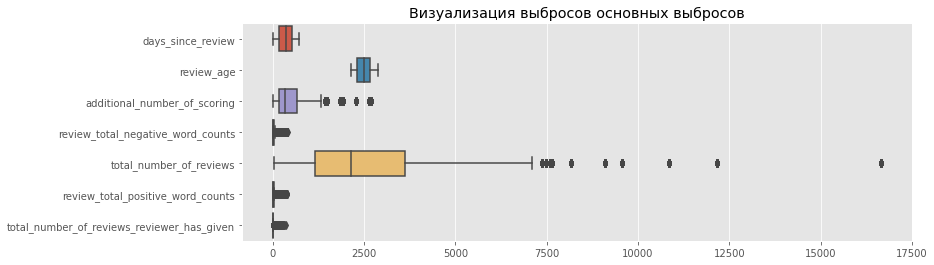

In [32]:
# Основные признаки
df_main_featurs = data[['days_since_review', 'review_age', 'additional_number_of_scoring', 'review_total_negative_word_counts',
     'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']]

# Коробчатая диаграмма для быстрого определения выбросов
fig = plt.figure(figsize=(12, 4))
boxplot = sns.boxplot(data=df_main_featurs, orient='h')
boxplot.set_title('Визуализация выбросов основных выбросов');

Можем условиться, что выбросов нет по признакам *days_since_review* и *review_age*. К ним и применем метод нормализации *MinMaxScaler*

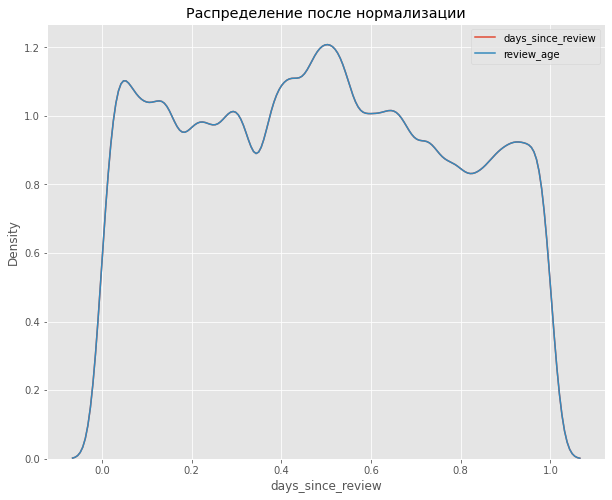

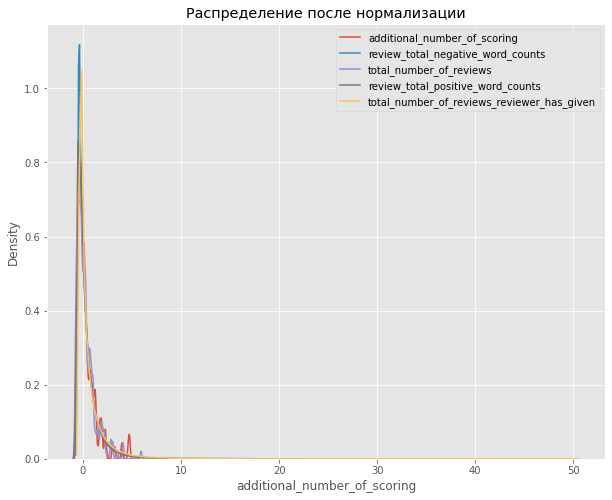

In [33]:
# Колонны без выбросов
col_list = data[['days_since_review', 'review_age']].columns.tolist()

# Список с колоннами имеющие выбросы
outliers_col = df_main_featurs.drop(col_list, axis=1).columns.tolist()

# Нормализуем колонны без выбрасов
mm_scal = preprocessing.MinMaxScaler()
data[col_list] = mm_scal.fit_transform(data[col_list])

# Смотрим на распределение
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределение после нормализации')
for col in col_list:
       sns.kdeplot(data[col], ax=ax1, label=col)
plt.legend();

# Нориализуем колонны с выбросами
r_scal = preprocessing.RobustScaler()
data[outliers_col] = r_scal.fit_transform(data[outliers_col])

# Строим распределение
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределение после нормализации')
for col in outliers_col:
       sns.kdeplot(data[col], ax=ax1, label=col)
plt.legend();

*Первый график показывает, что два признака полностью "скоррелировались". Это будет видно при отборе признаков. В последсвии избавимся от одного из них.*

### <center> Отбор признаков

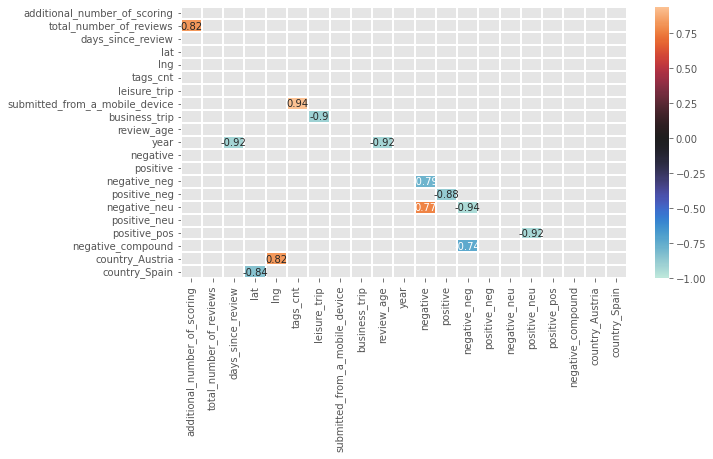

In [34]:
# Построим корреляцию и отфильтруем по сильной взаимосвязи
df_corr = data.corr()
df_corr = df_corr[(df_corr < 1) & (abs(df_corr) > 0.7)]
df_corr = df_corr.dropna(thresh=1, axis=0)
df_corr = df_corr.dropna(thresh=1, axis=1)
matrix = np.triu(df_corr)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.heatmap(df_corr, annot=True, ax=ax, center=0, mask=matrix, vmin=-1, linewidths=1.5);

In [35]:
# Удалим мультиколлинеальные признаки
data = data.drop(
    ['business_trip', 'additional_number_of_scoring', 'year', 'submitted_from_a_mobile_device',
    'days_since_review', 'negative_neu'],
    axis=1
)

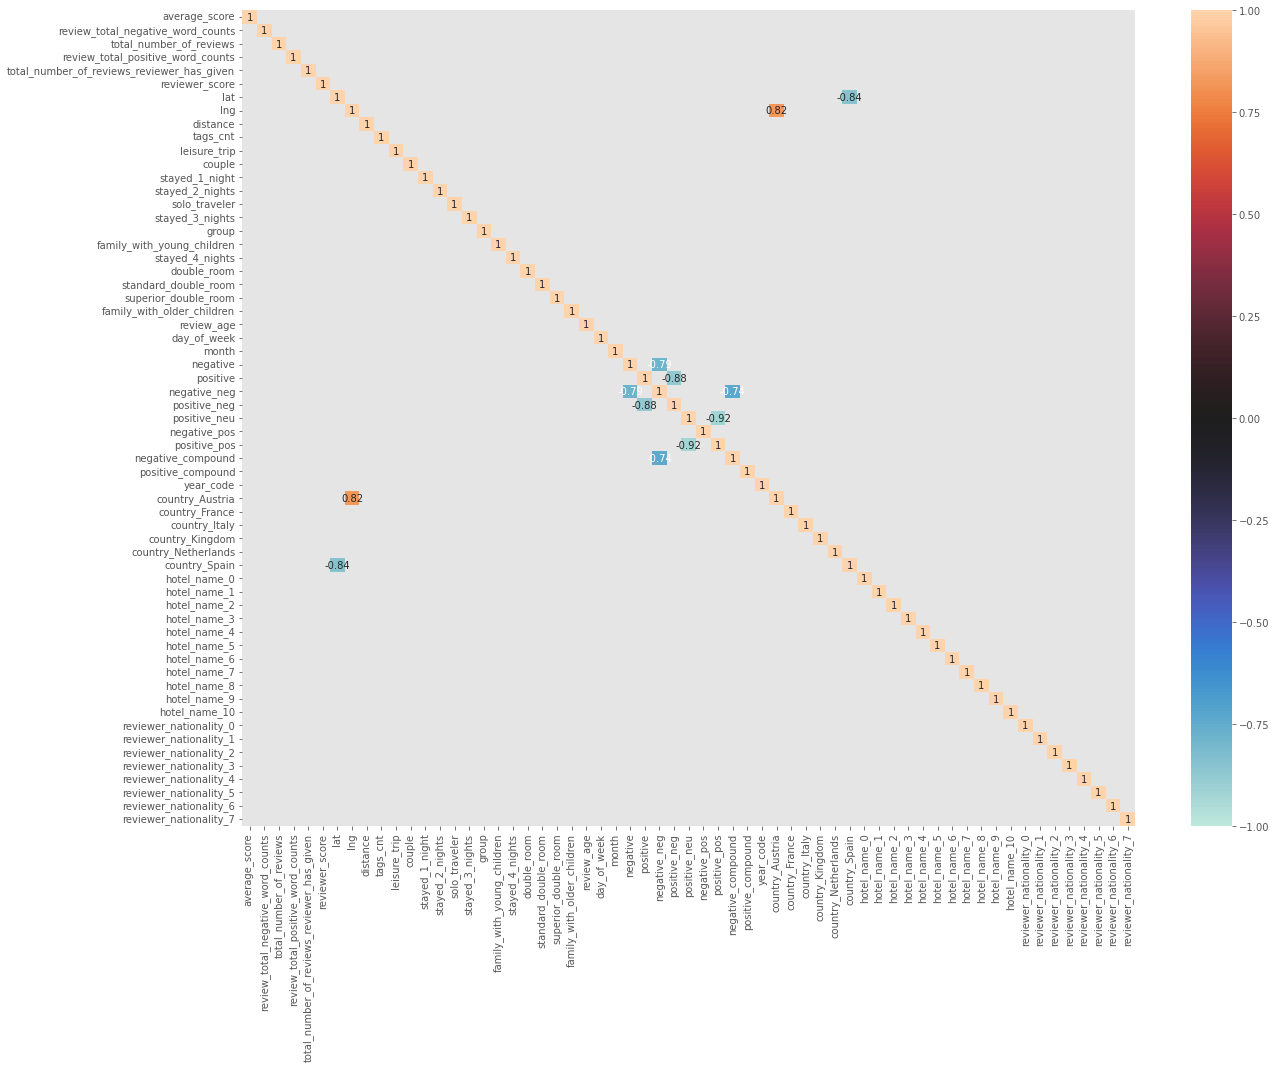

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mask = np.array(abs(data.corr()) < 0.7)
sns.heatmap(data.corr(), annot=True, ax=ax, center=0, vmin=-1, mask=mask);

In [37]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)
X = data.drop(['reviewer_score'], axis = 1)
y = data['reviewer_score']

# Непрерывные признаки
num_cols = ['review_total_negative_word_counts', 'total_number_of_reviews', 'lng', 'negative_compound',
            'positive_compound', 'positive_neg', 'positive_neu', 'positive_pos', 'negative_neg', 'distance',
            'negative_pos', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']
# Категориальные признаки
cat_cols = X.drop(num_cols, axis=1).columns.tolist()

Построим рейтинг непрерывных признаков влияющих на целевой признак с помощью теста *ANOVA*.

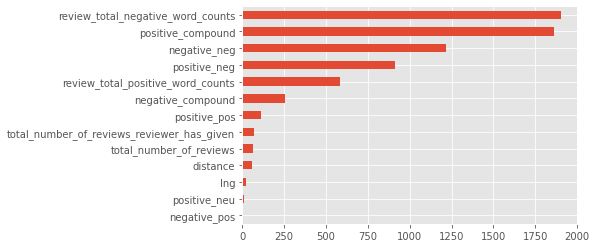

In [38]:
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

Построим рейтинг категориальных признаков влияющих на целевой признак с помощью теста *$X^2$*.

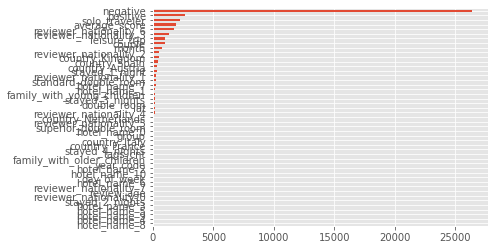

In [39]:
y = y.astype('int')

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

Оставим некоторые сомнительные признаки по принципу "чем больше, тем лучше".

### <center> Построение ML-модели

In [40]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.14646801142303648
